In [1]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsforecast import StatsForecast
from statsforecast.models import ARIMA
from utilsforecast.evaluation import evaluate
import warnings
import logging

warnings.filterwarnings("ignore", category=FutureWarning)
logging.getLogger("optuna").setLevel(logging.WARNING)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
# Definir las métricas
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def mape(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

def evaluate(cv_df, metrics):
    results = {}
    for metric in metrics:
        y_true = cv_df['y'].values
        y_pred = cv_df['ARIMA'].values
        results[metric.__name__] = metric(y_true, y_pred)
    return results

In [3]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2000-01-01', interval='1mo')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)

[*********************100%%**********************]  8 of 8 completed


In [4]:
def optimize_for_ticker(ticker):
    Y_df_ticker = Y_df[Y_df['unique_id'] == ticker]
    
    # Verifica el número de observaciones
    print(f"Number of observations for {ticker}: {len(Y_df_ticker)}")
    
    # Manejo de NaN
    if Y_df_ticker['y'].isnull().any():
        print(f"NaN values found in {ticker}.")
        return None  # Manejar según sea necesario

    # Definir función objetivo para Optuna
    def objective(trial):
        # Definir el espacio de búsqueda de hiperparámetros
        order = (trial.suggest_int('p', 0, 3), 
                 trial.suggest_int('d', 0, 2), 
                 trial.suggest_int('q', 0, 3))
        seasonal_order = (trial.suggest_int('P', 0, 3), 
                          trial.suggest_int('D', 0, 2), 
                          trial.suggest_int('Q', 0, 3))
        season_length = trial.suggest_int('season_length', 1, min(12, len(Y_df_ticker)))

        # Instanciar el modelo ARIMA
        model = ARIMA(order=order, 
                      seasonal_order=seasonal_order, 
                      season_length=season_length)

        # Instanciar StatsForecast
        sf = StatsForecast(df=Y_df_ticker, models=[model], freq='MS', n_jobs=-1)

        # Validación cruzada
        horizon = 6  
        cv_df = sf.cross_validation(df=Y_df_ticker, h=horizon, step_size=horizon, n_windows=5)
        cv_df = cv_df.reset_index()

        # Evaluar las predicciones
        evaluation_results = evaluate(cv_df.loc[:, cv_df.columns != 'cutoff'], metrics=[smape, mape, mse, mae, rmse])

        # Obtener SMAPE para la optimización
        smape_value = evaluation_results['smape']
        return smape_value

    # Configurar y ejecutar la optimización con Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=25)

    # Mostrar los mejores parámetros
    best_params = study.best_params
    print(f"Best hyperparameters for {ticker}: {best_params}")
    print(f"Best SMAPE for {ticker}: {study.best_value}")

    return best_params


In [5]:
def create_model_and_predict(ticker, best_params):
    Y_df_ticker = Y_df[Y_df['unique_id'] == ticker]

    # Crear y ajustar el modelo final con los mejores parámetros
    final_model = ARIMA(
        order=(best_params['p'], best_params['d'], best_params['q']),
        seasonal_order=(best_params['P'], best_params['D'], best_params['Q']),
        season_length=best_params['season_length']
    )

    # Instanciar StatsForecast con el modelo final
    sf_final = StatsForecast(df=Y_df_ticker, models=[final_model], freq='MS', n_jobs=-1)

    # Definir el horizonte de predicción
    horizon = 3
    prediction_length = int(len(Y_df_ticker)) - horizon
    Y_df_real = Y_df_ticker[:prediction_length]
    Y_df_test = Y_df_ticker[prediction_length:]

    # Ajustar el modelo
    sf_final.fit(Y_df_real)

    # Realizar predicciones
    forecast = sf_final.forecast(h=horizon)
    
    print(f"Predictions for {ticker}:")
    print(forecast)

    return forecast

In [6]:
def plot_predictions(ticker, forecast):
    Y_df_ticker = Y_df[Y_df['unique_id'] == ticker]
    
    # Graficar
    plt.figure(figsize=(10, 5))

    # Datos reales
    real_series = Y_df_ticker[['ds', 'y']]  
    plt.plot(real_series['ds'], real_series['y'], label='Actual Data', linestyle='-', color='blue', linewidth=2)

    # Predicciones
    forecast_series = forecast[['ds', 'ARIMA']]
    plt.plot(forecast_series['ds'], forecast_series['ARIMA'], label='Prediction', marker='x', color='orange')

    # Configurar el gráfico
    plt.title(f'Predictions vs Actual Data for {ticker}', fontsize=14)  
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend(fontsize=10)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(visible=True, linestyle='--', alpha=0.5)

    # Mostrar el gráfico
    plt.show()

In [7]:
# Diccionario para almacenar los mejores parámetros
best_params_dict = {}

# Bucle 1: Optimización para todos los tickers
for ticker in tickers:
    print(f"\nOptimizando para {ticker}...")
    best_params = optimize_for_ticker(ticker)
    
    # Guardamos los mejores parámetros en el diccionario
    best_params_dict[ticker] = best_params



Optimizando para AAPL...
Number of observations for AAPL: 298
Best hyperparameters for AAPL: {'p': 3, 'd': 0, 'q': 2, 'P': 0, 'D': 1, 'Q': 2, 'season_length': 9}
Best SMAPE for AAPL: 9.297103434801102

Optimizando para MSFT...
Number of observations for MSFT: 298
Best hyperparameters for MSFT: {'p': 3, 'd': 2, 'q': 2, 'P': 3, 'D': 0, 'Q': 0, 'season_length': 5}
Best SMAPE for MSFT: 10.313630849123001

Optimizando para GOOGL...
Number of observations for GOOGL: 242
Best hyperparameters for GOOGL: {'p': 3, 'd': 0, 'q': 2, 'P': 0, 'D': 1, 'Q': 2, 'season_length': 12}
Best SMAPE for GOOGL: 7.785291224718094

Optimizando para AMZN...
Number of observations for AMZN: 298
Best hyperparameters for AMZN: {'p': 1, 'd': 1, 'q': 2, 'P': 3, 'D': 1, 'Q': 1, 'season_length': 4}
Best SMAPE for AMZN: 11.686999350786209

Optimizando para NVDA...
Number of observations for NVDA: 298
Best hyperparameters for NVDA: {'p': 2, 'd': 0, 'q': 2, 'P': 3, 'D': 2, 'Q': 1, 'season_length': 2}
Best SMAPE for NVDA: 3

In [8]:
# Diccionario para almacenar las predicciones
forecasts_dict = {}

# Bucle 2: Creación del modelo y predicción para todos los tickers
for ticker in tickers:
    print(f"\nCreando el modelo y realizando predicciones para {ticker}...")
    
    # Usamos los mejores parámetros almacenados para cada ticker
    best_params = best_params_dict[ticker]
    
    # Creamos el modelo y realizamos las predicciones
    forecast = create_model_and_predict(ticker, best_params)
    
    # Guardamos las predicciones en el diccionario
    forecasts_dict[ticker] = forecast


Creando el modelo y realizando predicciones para AAPL...
Predictions for AAPL:
                  ds       ARIMA
unique_id                       
AAPL      2024-08-01  220.830688
AAPL      2024-09-01  220.224564
AAPL      2024-10-01  225.838318

Creando el modelo y realizando predicciones para MSFT...
Predictions for MSFT:
                  ds       ARIMA
unique_id                       
MSFT      2024-08-01  422.139191
MSFT      2024-09-01  421.983612
MSFT      2024-10-01  427.026093

Creando el modelo y realizando predicciones para GOOGL...
Predictions for GOOGL:
                  ds       ARIMA
unique_id                       
GOOGL     2024-08-01  174.139679
GOOGL     2024-09-01  167.954880
GOOGL     2024-10-01  172.967178

Creando el modelo y realizando predicciones para AMZN...
Predictions for AMZN:
                  ds       ARIMA
unique_id                       
AMZN      2024-08-01  187.292542
AMZN      2024-09-01  189.008499
AMZN      2024-10-01  192.218887

Creando el modelo


Graficando las predicciones para AAPL...


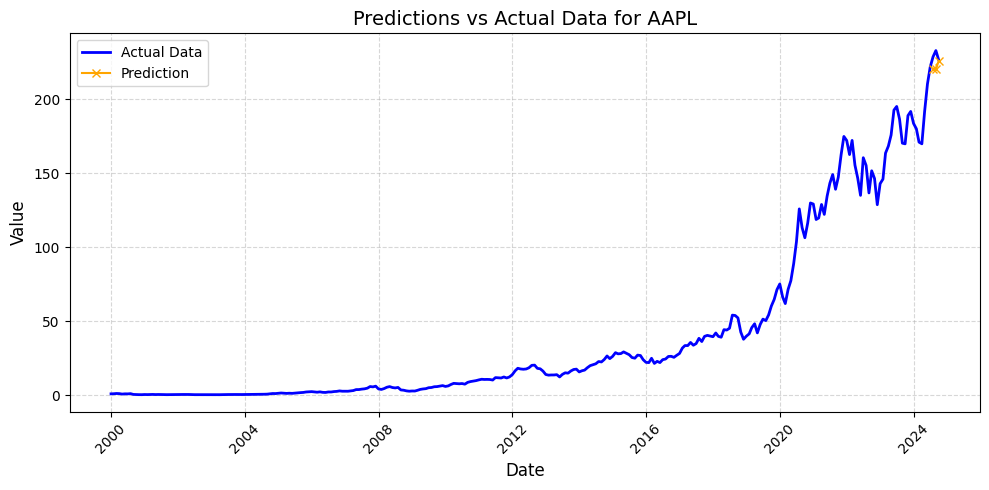


Graficando las predicciones para MSFT...


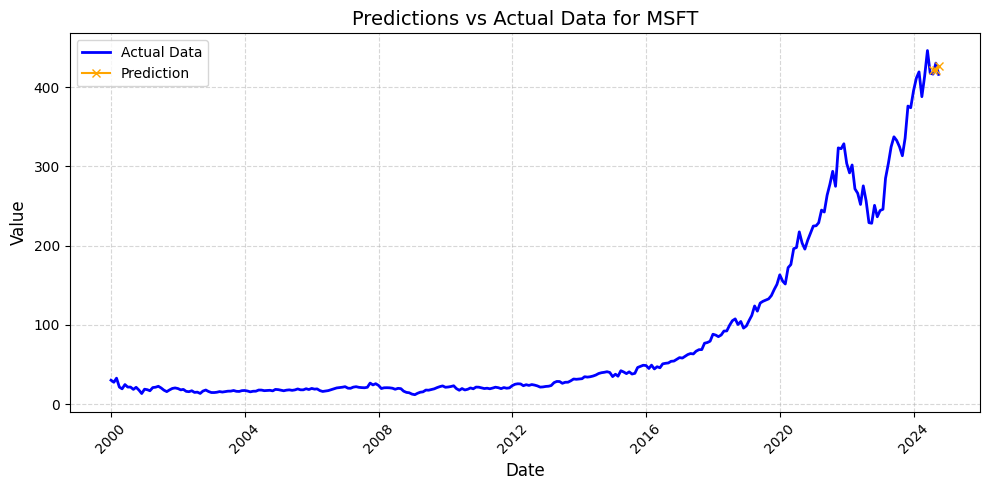


Graficando las predicciones para GOOGL...


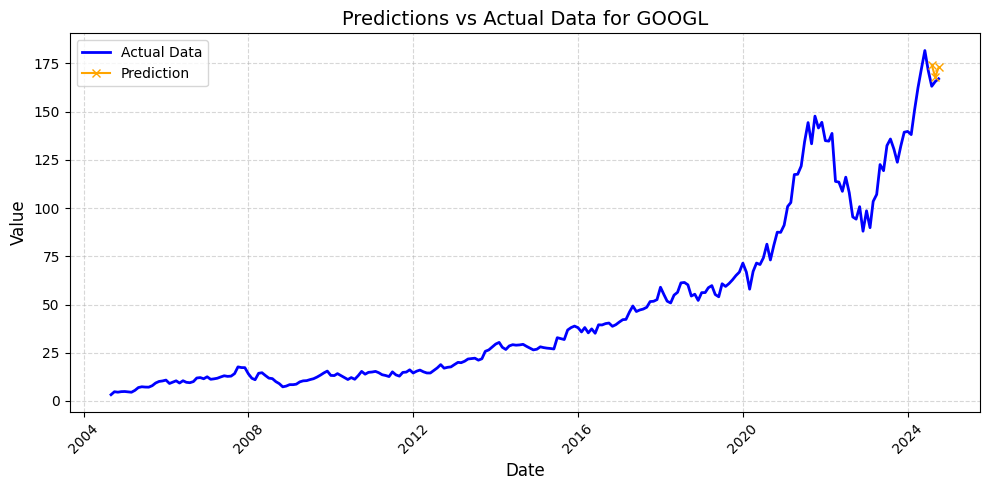


Graficando las predicciones para AMZN...


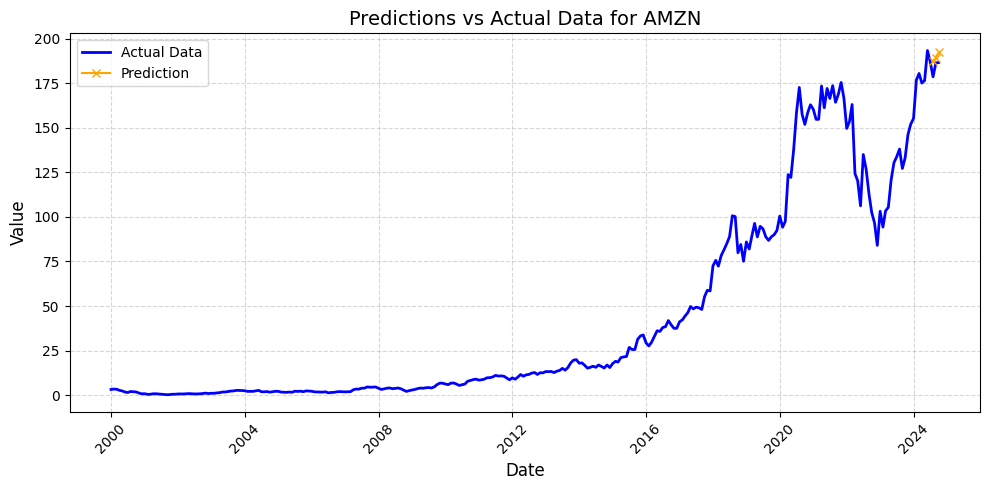


Graficando las predicciones para NVDA...


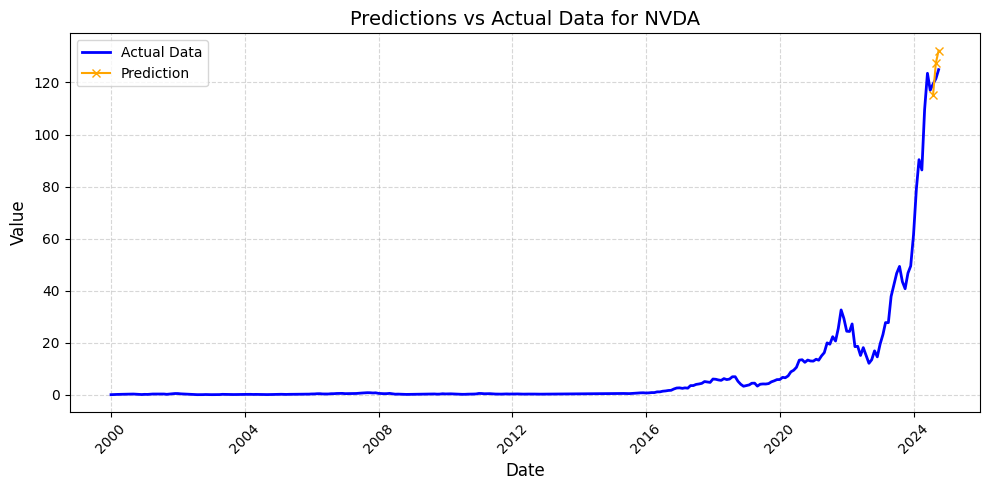


Graficando las predicciones para META...


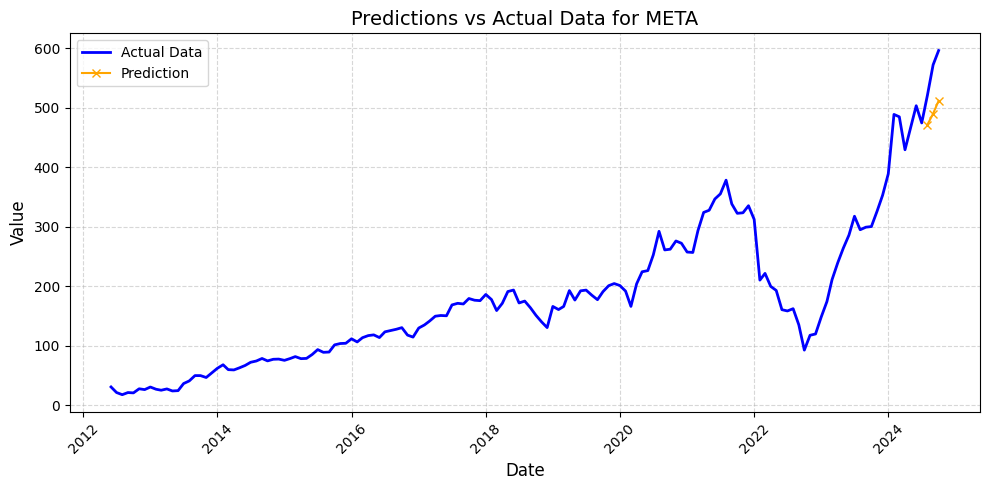


Graficando las predicciones para IBM...


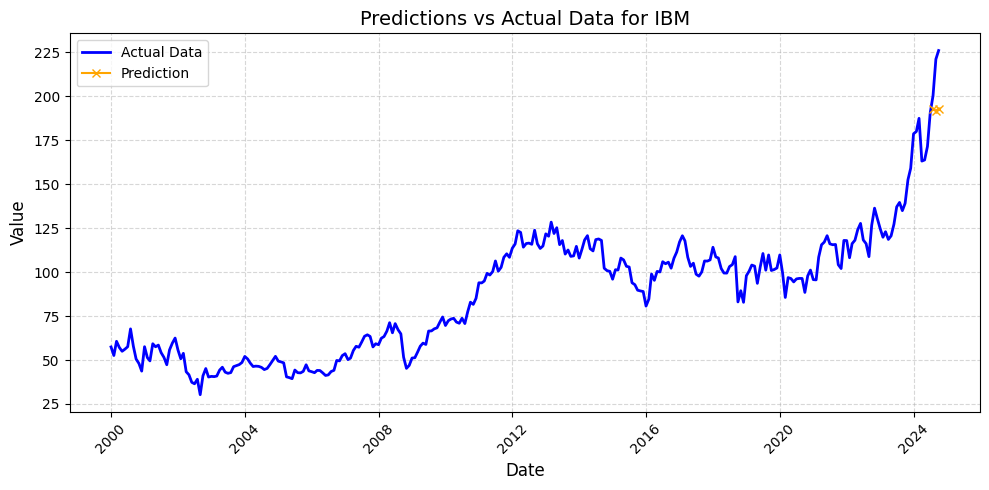


Graficando las predicciones para BTC-USD...


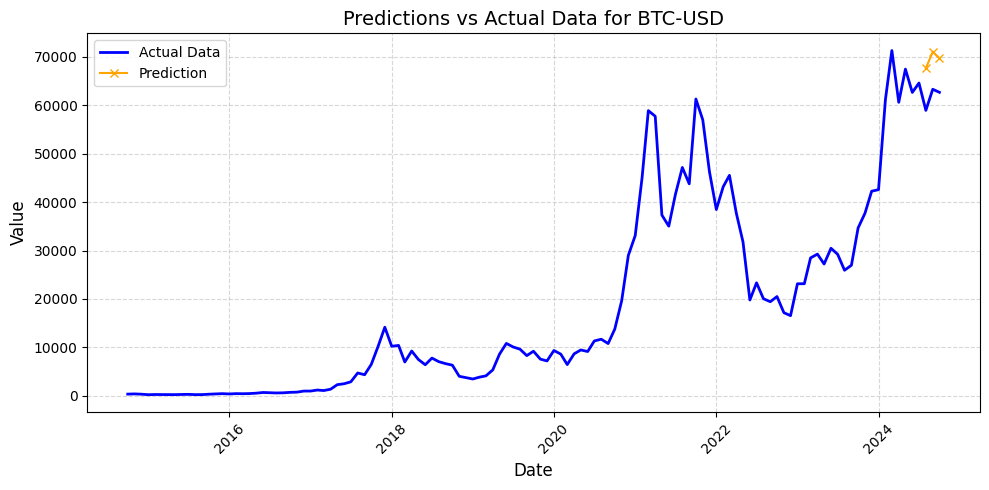

In [9]:
# Bucle 3: Visualización de las predicciones para todos los tickers
for ticker in tickers:
    print(f"\nGraficando las predicciones para {ticker}...")
    
    # Usamos las predicciones almacenadas para cada ticker
    forecast = forecasts_dict[ticker]
    
    # Graficamos las predicciones
    plot_predictions(ticker, forecast)
